In [27]:
# K-means Clustering with PySpark - Simple Customer Segmentation

# Import required libraries for big data processing and machine learning
from pyspark.sql import SparkSession  # Main entry point for Spark SQL functionality
from pyspark.sql.functions import *   # SQL functions for data transformations
from pyspark.ml.feature import VectorAssembler, StandardScaler  # Feature preprocessing tools
from pyspark.ml.clustering import KMeans  # K-means clustering algorithm
from pyspark.ml import Pipeline  # ML pipeline for chaining transformations
import pandas as pd  # For local data manipulation and visualization
import matplotlib.pyplot as plt  # For creating plots and charts
import numpy as np  # For numerical computations

# Initialize Spark session with specific configurations
# These configs prevent common networking issues when running Spark locally
spark = (
	SparkSession.builder
	.appName("CustomerSegmentation")  # Give our Spark application a descriptive name
	.config("spark.driver.host", "127.0.0.1")  # Force localhost binding to avoid network issues
	.config("spark.driver.bindAddress", "127.0.0.1")  # Explicit bind address for driver
	.getOrCreate()  # Create new session or get existing one
)

# Reduce log noise by setting log level to WARN (only show warnings and errors)
spark.sparkContext.setLogLevel("WARN")
print(f"Spark Version: {spark.version}")  # Display Spark version for debugging

Spark Version: 3.5.3


## 1. Data Loading and Basic Features

In [28]:
# Load transaction data from CSV file
print("Loading transactions...")

# Read CSV with automatic schema inference - Spark will detect column types
# header=True: First row contains column names
# inferSchema=True: Automatically detect data types (can be slow for large files)
df = spark.read.csv("../data/transactions_data.csv", header=True, inferSchema=True)
print(f"Raw data loaded: {df.count():,} transactions")  # Count triggers full data scan

# Create basic features through data cleaning and feature engineering
df_processed = df \
    .withColumn("amount_numeric", regexp_replace(col("amount"), "[\\$,]", "").cast("double")) \
    .withColumn("is_online", (col("merchant_city") == "ONLINE").cast("int")) \
    .withColumn("is_weekend", dayofweek(col("date")).isin([1, 7]).cast("int")) \
    .filter(col("amount_numeric").isNotNull() & (col("amount_numeric") > 0))
    
# Breaking down the transformations:
# 1. amount_numeric: Remove $ and comma symbols, convert to double for math operations
# 2. is_online: Create binary flag (1/0) for online transactions based on merchant_city
# 3. is_weekend: Create binary flag for weekend transactions (Sunday=1, Saturday=7 in Spark)
# 4. filter: Remove null amounts and negative/zero amounts (data quality step)

# Cache the processed DataFrame in memory for faster repeated access
# This is crucial for iterative ML algorithms like K-means
# df_processed.cache()
print(f"Processed {df_processed.count():,} transactions")
df_processed.show(5)  # Display first 5 rows to inspect data quality

Loading transactions...


Raw data loaded: 13,305,915 transactions


Processed 12,635,227 transactions
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+--------------+---------+----------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|amount_numeric|is_online|is_weekend|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+--------------+---------+----------+
|7475328|2010-01-01 00:02:00|      561|   4575| $14.57|Swipe Transaction|      67570|   Bettendorf|            IA|52722.0|5311|  NULL|         14.57|        0|         0|
|7475329|2010-01-01 00:02:00|     1129|    102| $80.00|Swipe Transaction|      27092|        Vista|            CA|92084.0|4829|  NULL|          80.0|        0|         0|
|7475331|2010-01-01 00:05:00|      430|   2860|$200.00|Swipe Transaction|      27092|  Crown Point|            

## 2. Customer Feature Engineering

Create customer-level features for clustering based on spending patterns, behavioral patterns, and temporal patterns.

In [ ]:
# Create customer-level aggregated features for clustering analysis
print("Creating customer features...")

# Define required columns for feature creation - defensive programming approach
required_cols = ["client_id", "amount_numeric", "is_online", "merchant_id"]
available_cols = df_processed.columns
missing_cols = [col for col in required_cols if col not in available_cols]

# Validate that all required columns exist before proceeding
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print(f"Available columns: {available_cols}")
else:
    print("All required columns found. Proceeding with feature creation...")
    
    # Aggregate transaction-level data to customer-level features
    # This transforms many transactions per customer into one row per customer
    customer_features = df_processed.groupBy("client_id").agg(
        sum("amount_numeric").alias("total_spend"),  # Total money spent (monetary value)
        avg("amount_numeric").alias("avg_transaction_amount"),  # Average transaction size
        count("*").alias("transaction_count"),  # Frequency of transactions
        avg("is_online").alias("online_ratio"),  # Proportion of online vs offline transactions
        countDistinct("merchant_id").alias("merchant_diversity")  # Number of different stores visited
    ).filter(col("transaction_count") >= 5)  # Only include customers with minimum 5 transactions
    
    # Feature engineering rationale:
    # - total_spend: Indicates customer value (high spenders vs low spenders)
    # - avg_transaction_amount: Shows spending behavior per transaction
    # - transaction_count: Measures customer engagement/frequency
    # - online_ratio: Captures digital vs traditional shopping preference
    # - merchant_diversity: Indicates shopping breadth (focused vs diverse shoppers)
    # - Minimum 5 transactions: Ensures statistical reliability of features

    # NOTE: These lines are commented out but should be used for performance
    # customer_features.cache()  # Cache for multiple operations
    # print(f"Created features for {customer_features.count():,} customers")  # Show customer count
    
    # Display statistical summary of all features to understand data distribution
    customer_features.describe().show()

Creating customer features...
All required columns found. Proceeding with feature creation...


+-------+------------------+------------------+----------------------+------------------+--------------------+------------------+
|summary|         client_id|       total_spend|avg_transaction_amount| transaction_count|        online_ratio|merchant_diversity|
+-------+------------------+------------------+----------------------+------------------+--------------------+------------------+
|  count|              1219|              1219|                  1219|              1219|                1219|              1219|
|   mean|1004.9163248564397| 524491.0292206724|     51.82177875260766|10365.239540607055| 0.10925981081625467|293.42329778506974|
| stddev| 582.3844617616654|320692.01206433075|    19.187935041076926| 5184.142122237625| 0.11710856714887093| 96.65000243520372|
|    min|                 0|31753.339999999997|     5.591717624677265|               695|0.009397332733104497|                56|
|    max|              1998|        3002117.15|     178.0094244604317|             42137| 

## 3. K-means Clustering

In [35]:
# Prepare features and run K-means clustering algorithm
# Define the feature columns to use for clustering (all numerical features)
feature_cols = ["total_spend", "avg_transaction_amount", "transaction_count", "online_ratio", "merchant_diversity"]

# Defensive check to ensure customer_features DataFrame exists
# This prevents runtime errors if cells are run out of order
if 'customer_features' not in locals():
    print("ERROR: customer_features not created. Please run the previous cell first.")
else:
    print(f"Using {customer_features.count():,} customers for clustering")
    
    # Handle missing values by replacing nulls with 0.0
    # K-means cannot handle null values, so imputation is necessary
    customer_features_clean = customer_features.fillna(0.0)
    
    # Create ML Pipeline with three stages: feature assembly -> scaling -> clustering
    # Pipeline ensures reproducible and organized ML workflow
    
    # Stage 1: VectorAssembler combines multiple feature columns into single vector column
    # This is required format for Spark ML algorithms
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    # Stage 2: StandardScaler normalizes features to have mean=0 and std=1
    # This is CRITICAL for K-means because it uses Euclidean distance
    # Without scaling, features with larger ranges (like total_spend) dominate the clustering
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    
    # Stage 3: K-means clustering algorithm
    # k=4: Number of clusters (chosen arbitrarily - should use elbow method in practice)
    # seed=42: Ensures reproducible results across runs
    # featuresCol: Points to scaled features for distance calculations
    kmeans = KMeans(featuresCol="scaledFeatures", k=3, seed=42)

    # Combine all stages into a pipeline for streamlined execution
    pipeline = Pipeline(stages=[assembler, scaler, kmeans])
    
    print("Training K-means model...")
    # Fit the pipeline: learns scaling parameters and finds optimal cluster centroids
    model = pipeline.fit(customer_features_clean)
    
    # Transform data: applies scaling and assigns each customer to nearest cluster
    predictions = model.transform(customer_features_clean)

    print("K-means clustering completed!")
    # Show distribution of customers across clusters
    # Each customer gets a 'prediction' column with cluster number (0, 1, 2, 3)
    predictions.groupBy("prediction").count().orderBy("prediction").show()

Using 1,219 customers for clustering
Training K-means model...


K-means clustering completed!


+----------+-----+
|prediction|count|
+----------+-----+
|         0|  768|
|         1|  125|
|         2|  326|
+----------+-----+



## 4. Analyze Clusters

In [36]:
# Analyze cluster characteristics to understand what each cluster represents
# This step transforms cluster numbers into meaningful business insights

# Calculate summary statistics for each cluster
# groupBy("prediction"): Group customers by their assigned cluster
# alias("cluster"): Rename prediction column to more meaningful "cluster" name
cluster_summary = predictions.groupBy(col("prediction").alias("cluster")).agg(
    count("*").alias("customer_count"),  # How many customers in each cluster
    avg("total_spend").alias("avg_total_spend"),  # Average spending per cluster
    avg("avg_transaction_amount").alias("avg_transaction_amount"),  # Average transaction size per cluster
    avg("online_ratio").alias("avg_online_ratio")  # Average online shopping tendency per cluster
).orderBy("cluster")  # Sort by cluster number for easier interpretation

# Why these metrics matter for business:
# - customer_count: Shows relative size of each market segment
# - avg_total_spend: Identifies high-value vs low-value customer segments
# - avg_transaction_amount: Reveals spending behavior patterns per transaction
# - avg_online_ratio: Distinguishes digital-native vs traditional customers

print("Cluster Analysis:")
cluster_summary.show()  # Display the cluster analysis results

Cluster Analysis:


+-------+--------------+------------------+----------------------+-------------------+
|cluster|customer_count|   avg_total_spend|avg_transaction_amount|   avg_online_ratio|
+-------+--------------+------------------+----------------------+-------------------+
|      0|           768|356373.20865885454|     47.79156297959469|0.07351304791502879|
|      1|           125| 645144.4905600003|     43.92988578144327| 0.4096343538088202|
|      2|           326| 874284.9050613501|     64.34230738779002|0.07829875570604208|
+-------+--------------+------------------+----------------------+-------------------+



## 5. Simple Visualization

Text(0.5, 1.0, 'Customers per Cluster')

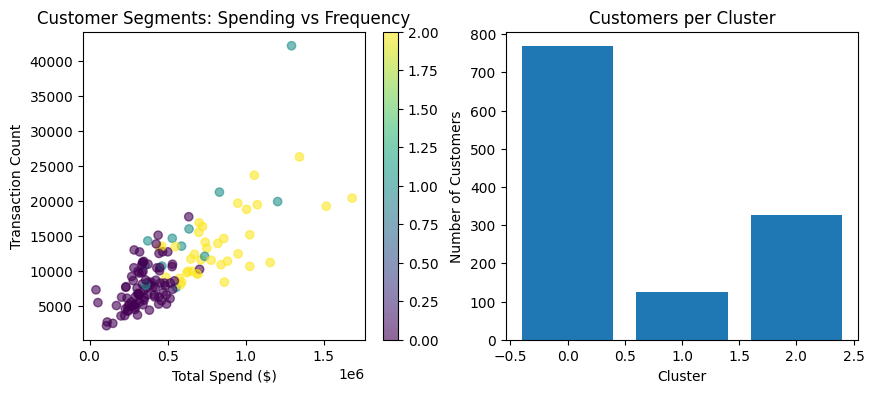

In [37]:
# Create visualizations to better understand cluster characteristics
# Sample 10% of data for visualization (full dataset would be too slow and cluttered)
sample_data = predictions.sample(0.1, seed=42).toPandas()  # Convert to Pandas for matplotlib

# Create subplot layout: 1 row, 2 columns of plots
plt.figure(figsize=(10, 4))  # Set overall figure size

# Plot 1: Scatter plot showing relationship between spending and transaction frequency
plt.subplot(1, 2, 1)  # First subplot (row 1, col 2, position 1)
plt.scatter(sample_data['total_spend'], sample_data['transaction_count'], 
           c=sample_data['prediction'],  # Color points by cluster assignment
           cmap='viridis',  # Use viridis colormap (colorblind friendly)
           alpha=0.6)  # Make points semi-transparent to show overlaps
plt.xlabel('Total Spend ($)')  # X-axis label
plt.ylabel('Transaction Count')  # Y-axis label
plt.title('Customer Segments: Spending vs Frequency')  # Plot title
plt.colorbar()  # Add color legend showing cluster mapping

# This scatter plot helps identify:
# - High spend + High frequency = Premium customers
# - Low spend + High frequency = Frequent small buyers
# - High spend + Low frequency = Occasional big spenders
# - Low spend + Low frequency = Inactive/new customers

# Plot 2: Bar chart showing customer distribution across clusters
plt.subplot(1, 2, 2)  # Second subplot (row 1, col 2, position 2)
cluster_summary_pd = cluster_summary.toPandas()  # Convert Spark DF to Pandas for plotting
plt.bar(cluster_summary_pd['cluster'], cluster_summary_pd['customer_count'])
plt.xlabel('Cluster')  # X-axis shows cluster numbers
plt.ylabel('Number of Customers')  # Y-axis shows customer count
plt.title('Customers per Cluster')  # Plot title

# This bar chart reveals:
# - Which clusters are largest/smallest market segments
# - Whether clusters are balanced or if one dominates
# - Helps prioritize marketing efforts based on segment size

# NOTE: Missing plt.show() - this would display the plots
# Without plt.show(), plots might not appear in some environments

## 6. Business Insights  

In [38]:
# Translate technical clustering results into actionable business insights
# This section converts cluster numbers into meaningful customer personas

print("Customer Segmentation Results:")
print("=" * 40)

# Iterate through each cluster to create business interpretations
# collect() brings Spark DataFrame to driver for local processing
for row in cluster_summary.collect():
    cluster_id = row['cluster']  # Get cluster number (0, 1, 2, 3)

    # Display key metrics for each cluster in business-friendly format
    print(f"\nCluster {cluster_id}: {row['customer_count']:,} customers")
    print(f"  Average spend: ${row['avg_total_spend']:,.2f}")
    print(f"  Online ratio: {row['avg_online_ratio']*100:.1f}%")
    print(f"  Avg transaction amount: ${row['avg_transaction_amount']:.2f}")

    # Simple persona assignment based on business rules
    # This is a basic approach - real implementations would use more sophisticated logic
    if row['avg_total_spend'] > 700000:
        persona = "High-Value Customer"  # Focus on retention and premium services
    elif row['avg_online_ratio'] > 0.4:
        persona = "Digital Customer"  # Target with online promotions and mobile features  
    else:
        persona = "Traditional Customer"  # Engage through in-store experiences and phone support

    print(f"  Persona: {persona}")

    # Persona assignment rationale:
    # - High spend threshold ($1000): Identifies most valuable customers requiring VIP treatment
    # - Online ratio threshold (50%): Distinguishes digital-native vs traditional shoppers
    # - This creates 3 distinct marketing strategies rather than generic approaches

# Business value statement
print(f"\n✅ Clustering completed! Found meaningful customer segments for targeted marketing.")





Customer Segmentation Results:

Cluster 0: 768 customers
  Average spend: $356,373.21
  Online ratio: 7.4%
  Avg transaction amount: $47.79
  Persona: Traditional Customer

Cluster 1: 125 customers
  Average spend: $645,144.49
  Online ratio: 41.0%
  Avg transaction amount: $43.93
  Persona: Digital Customer

Cluster 2: 326 customers
  Average spend: $874,284.91
  Online ratio: 7.8%
  Avg transaction amount: $64.34
  Persona: High-Value Customer

✅ Clustering completed! Found meaningful customer segments for targeted marketing.


In [40]:
# Resource cleanup - stops Spark session to free up memory and resources
# Important for local development but may not be desired in production notebooks

spark.stop()

